In [107]:
# Import necessary PySpark and plotting modules
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.functions import col, min as _min, sum as _sum, count, when, approx_count_distinct, avg

In [137]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Cluster Data Analysis") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

## Data Loading and Schema Definition

In [109]:
# Define the correct column names for machine_events
column_names = ["time", "machine_ID", "event_type", "platform_ID", "CPUs", "Memory"]

# Load dataset
df = spark.read.csv("../data/machine_events-part-00000-of-00001.csv.gz", header=False, inferSchema=True)

# Rename columns to the expected schema
df = df.toDF(*column_names)

In [110]:
# Define the correct column names for job_events
job_column_names = [
    "time", "missing_info", "job_ID", "event_type", "user", 
    "scheduling_class", "job_name", "logical_job_name"
]

# Load the job_events dataset
job_events_df = spark.read.csv("../data/job_events-part-00000-of-00500.csv.gz", header=False, inferSchema=True)

# Rename columns to the expected schema
job_events_df = job_events_df.toDF(*job_column_names)

In [111]:
# Define the correct column names for task_events
task_column_names = [
    "time", "missing_info", "job_ID", "task_index", "machine_ID", 
    "event_type", "user", "scheduling_class", "priority", 
    "CPU_request", "memory_request", "disk_space_request", 
    "different_machines_restriction"
]

# Load the task_events dataset
task_events_df = spark.read.csv("../data/task_events-part-00000-of-00500.csv.gz", header=False, inferSchema=True)

# Rename columns to the expected schema
task_events_df = task_events_df.toDF(*task_column_names)

In [112]:
# Define the correct column names for task_usage
task_usage_columns = [
    "start_time", "end_time", "job_ID", "task_index", "machine_ID", 
    "CPU_rate", "canonical_memory_usage", "assigned_memory_usage", "unmapped_page_cache", 
    "total_page_cache", "maximum_memory_usage", "disk_IO_time", "local_disk_space_usage", 
    "maximum_CPU_rate", "maximum_disk_IO_time", "cycles_per_instruction", 
    "memory_accesses_per_instruction", "sample_portion", "aggregation_type", "sampled_CPU_usage"
]

# Load the task_usage dataset
task_usage_df = spark.read.csv("../data/task_usage-part-00000-of-00500.csv.gz", header=False, inferSchema=True)

# Rename columns to the expected schema
task_usage_df = task_usage_df.toDF(*task_usage_columns)

## Q_1 : Machine Distribution by CPU Capacity
This section analyzes the distribution of machines according to their CPU capacity using Spark and visualizes the results with Matplotlib.

Group and Count by CPU Capacity :

In [113]:
# Distribution of machines according to their CPU capacity
# Group by CPU capacity and count
cpu_distribution = df.groupBy("CPUs").count().orderBy("CPUs")

# Show the CPU distribution result
cpu_distribution.show()

+----+-----+
|CPUs|count|
+----+-----+
|NULL|   32|
|0.25|  510|
| 0.5|35015|
| 1.0| 2223|
+----+-----+



Convert to Pandas and Visualize

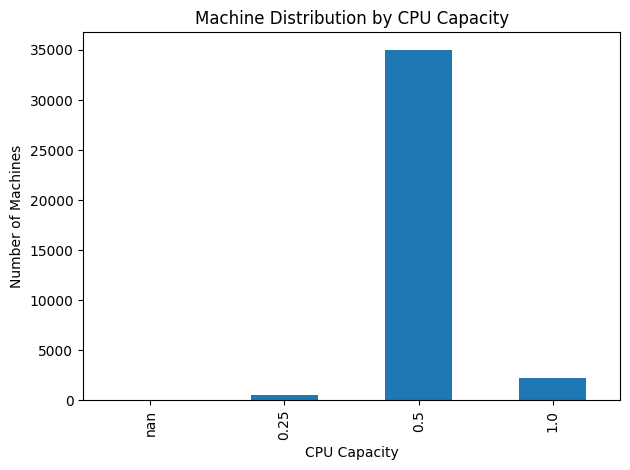

In [114]:
# Convert the results to a Pandas DataFrame for visualization
cpu_distribution_pd = cpu_distribution.toPandas()

# Plot the CPU distribution
cpu_distribution_pd.plot(kind="bar", x="CPUs", y="count", legend=False, title="Machine Distribution by CPU Capacity")
plt.xlabel("CPU Capacity")
plt.ylabel("Number of Machines")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig("../plots/q1_cpu_distribution.png")  # Save the chart as a PNG file
plt.show()


## Q_2 : Computational Power Lost Due to Maintenance
This section calculates the percentage of computational power lost due to machine maintenance by analyzing the earliest `ADD` and `REMOVE` events for each machine and visualizing the results as a pie chart.

Identify Earliest ADD Events :

In [115]:
# Identify the earliest ADD event for each machine (event_type = 0)
window_add = Window.partitionBy("machine_ID").orderBy(col("time").asc())
df_add = df.filter(df["event_type"] == 0).withColumn("rank", _min("time").over(window_add))
df_add = df_add.filter(col("rank") == col("time"))

Calculate Total CPU Capacity And Identify Earliest REMOVE Events :

In [116]:
# Calculate total CPU capacity from all added machines
total_cpu_capacity = df_add.agg(_sum("CPUs")).collect()[0][0]

# Identify the earliest REMOVE event for each machine (event_type = 1)
window_remove = Window.partitionBy("machine_ID").orderBy(col("time").asc())
df_remove = df.filter(df["event_type"] == 1).withColumn("rank", _min("time").over(window_remove))
df_remove = df_remove.filter(col("rank") == col("time"))

Calculate Total Lost CPU Capacity And Compute Percentage of Computational Power Lost :

In [117]:
# Calculate total lost CPU capacity from removed machines
lost_cpu_capacity = df_remove.agg(_sum("CPUs")).collect()[0][0]

# Compute the percentage of computational power lost
percentage_lost = (lost_cpu_capacity / total_cpu_capacity) * 100
print(f"Percentage of computational power lost due to maintenance: {percentage_lost:.2f}%")

Percentage of computational power lost due to maintenance: 40.92%


 Visualize the Results :

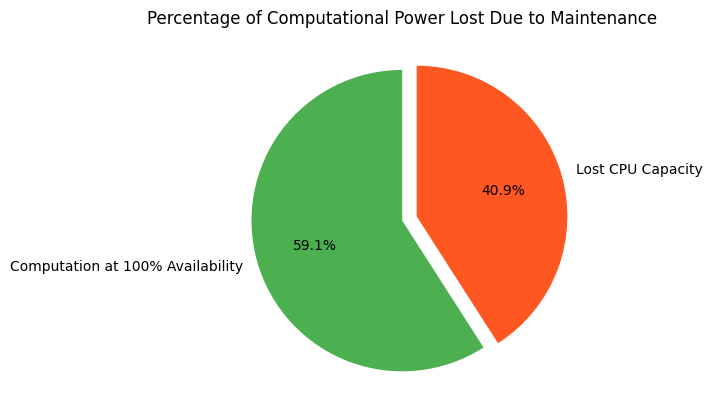

In [118]:
# Visualize the results as a pie chart
labels = ['Computation at 100% Availability', 'Lost CPU Capacity']
sizes = [total_cpu_capacity - lost_cpu_capacity, lost_cpu_capacity]
colors = ['#4CAF50', '#FF5722']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0, 0.1))
plt.title("Percentage of Computational Power Lost Due to Maintenance")
plt.tight_layout()
plt.savefig("../plots/q2_computational_power_loss.png")  # Save the chart as a PNG file
plt.show()

## Q_3 : Distribution of Jobs and Tasks by Scheduling Class
This section analyzes the distribution of jobs and tasks across scheduling classes using Spark and visualizes the results using bar charts.


 Calculate Distributions And Show Distributions :

In [119]:
# Distribution of jobs per scheduling class
job_distribution = job_events_df.groupBy("scheduling_class").count().orderBy("scheduling_class")

# Distribution of tasks per scheduling class
task_distribution = task_events_df.groupBy("scheduling_class").count().orderBy("scheduling_class")

# Show the distributions
print("Job Distribution by Scheduling Class:")
job_distribution.show()

print("Task Distribution by Scheduling Class:")
task_distribution.show()

Job Distribution by Scheduling Class:
+----------------+-----+
|scheduling_class|count|
+----------------+-----+
|               0| 2179|
|               1| 3610|
|               2| 3030|
|               3| 1885|
+----------------+-----+

Task Distribution by Scheduling Class:


[Stage 34:>                                                         (0 + 1) / 1]

+----------------+------+
|scheduling_class| count|
+----------------+------+
|               0|237969|
|               1| 58109|
|               2| 97482|
|               3| 56586|
+----------------+------+



Convert to Pandas for Visualization And Plot Job Distribution

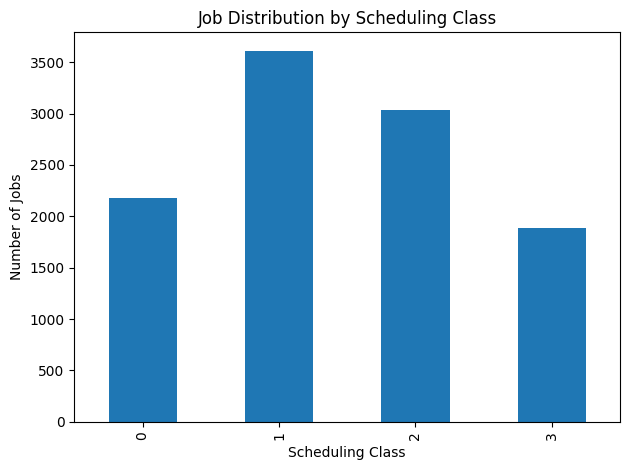

In [120]:
# Convert to Pandas for visualization
job_distribution_pd = job_distribution.toPandas()
task_distribution_pd = task_distribution.toPandas()

# Plot the job distribution
job_distribution_pd.plot(kind="bar", x="scheduling_class", y="count", legend=False, 
                          title="Job Distribution by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Number of Jobs")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig("../plots/q3_job_distribution_scheduling_class.png")  # Save the chart as a PNG file
plt.show()

Plot Task Distribution

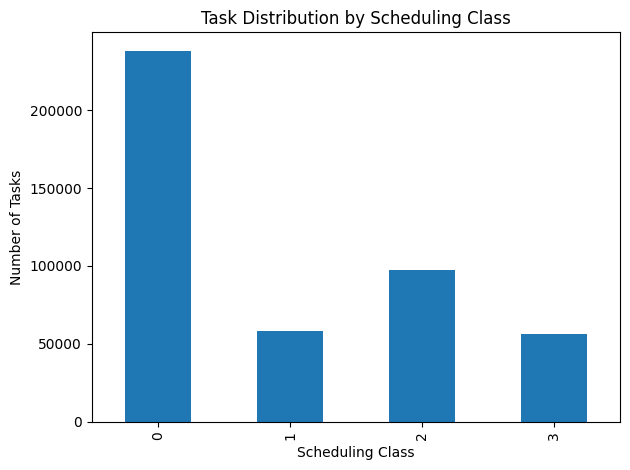

In [121]:
# Plot the task distribution
task_distribution_pd.plot(kind="bar", x="scheduling_class", y="count", legend=False, 
                           title="Task Distribution by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Number of Tasks")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig("../plots/q3_task_distribution_scheduling_class.png")  # Save the chart as a PNG file
plt.show()

## Q_4 : Eviction Rate by Scheduling Class
This section calculates the eviction rate of tasks per scheduling class, visualizes the results, and saves the chart.


Count Total Tasks Per Scheduling Class :

In [125]:
# Count total tasks per scheduling class
total_tasks = task_events_df.groupBy("scheduling_class").count().withColumnRenamed("count", "total_tasks")

Count Evicted Tasks Per Scheduling Class :

In [129]:
# Filter evicted tasks (event_type = 2) and group by scheduling_class, considering unique tasks
evicted_tasks = task_events_df.filter(col("event_type") == 2) \
    .groupBy("scheduling_class", "job_ID", "task_index") \
    .count() \
    .groupBy("scheduling_class") \
    .count().withColumnRenamed("count", "evicted_tasks")

Calculate Eviction Rate :

In [131]:
# Join the total tasks and evicted tasks datasets
eviction_rate_df = total_tasks.join(evicted_tasks, "scheduling_class", "left") \
    .fillna(0, subset=["evicted_tasks"])  # Fill missing evicted tasks with 0

# Calculate the eviction rate
eviction_rate_df = eviction_rate_df.withColumn(
    "eviction_rate",
    (col("evicted_tasks") / col("total_tasks")) * 100
)

# Show the eviction rate for each scheduling class
eviction_rate_df.select("scheduling_class", "total_tasks", "evicted_tasks", "eviction_rate").show()

# Convert to Pandas for visualization
eviction_rate_pd = eviction_rate_df.select("scheduling_class", "eviction_rate").toPandas()

+----------------+-----------+-------------+--------------------+
|scheduling_class|total_tasks|evicted_tasks|       eviction_rate|
+----------------+-----------+-------------+--------------------+
|               1|      58109|          704|  1.2115162883546438|
|               3|      56586|           18|0.031809988336337615|
|               2|      97482|          487|  0.4995794095320162|
|               0|     237969|         2715|   1.140904907782106|
+----------------+-----------+-------------+--------------------+



Plot Eviction Rate :

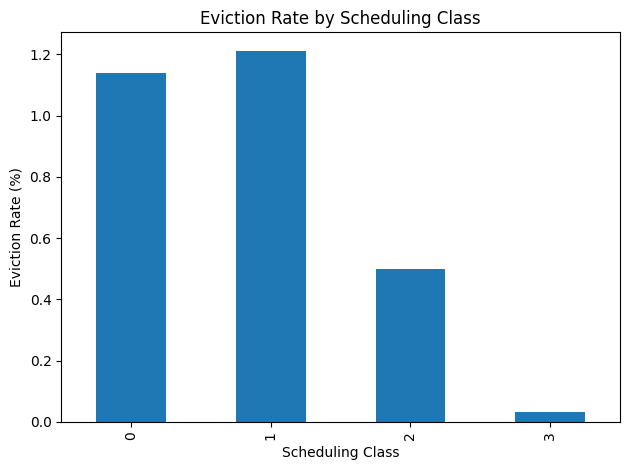

In [132]:

# Sort values for plotting
eviction_rate_pd = eviction_rate_pd.sort_values(by="scheduling_class")

# Plot the eviction rate
eviction_rate_pd.plot(kind="bar", x="scheduling_class", y="eviction_rate", legend=False, 
                       title="Eviction Rate by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Eviction Rate (%)")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig("../plots/q4_eviction_rate_by_scheduling_class.png")  # Save the chart as a PNG file
plt.show()


## Q_5 : Percentage of Jobs Where All Tasks Run on the Same Machine
This section calculates the percentage of jobs where all tasks are executed on the same machine by grouping tasks by `job_ID` and analyzing the unique `machine_ID`s used.


Calculate Jobs Running on the Same Machine :

In [138]:
# Group by job_ID and calculate the number of unique machine_IDs per job
job_machine_distribution = task_events_df.groupBy("job_ID") \
    .agg(
        count("task_index").alias("total_tasks"),
        approx_count_distinct("machine_ID").alias("unique_machines")
    )

# Calculate jobs where all tasks run on the same machine
same_machine_jobs = job_machine_distribution.filter(col("unique_machines") == 1).count()
total_jobs = job_machine_distribution.count()

Calculate the percentage of jobs where all tasks run on the same machine

In [139]:
same_machine_percentage = (same_machine_jobs / total_jobs) * 100

print(f"Percentage of jobs where all tasks run on the same machine: {same_machine_percentage:.2f}%")


Percentage of jobs where all tasks run on the same machine: 62.66%


## Q_6 : Correlation Between Requested and Consumed Resources
This section analyzes the correlation between requested and consumed CPU and memory resources by joining the `task_events` and `task_usage` datasets.


Join and select relevant columns from datasets : 

In [141]:
# Join task_events and task_usage datasets on job_ID and task_index
combined_df = task_events_df.join(task_usage_df, ["job_ID", "task_index"], "inner")

# Select relevant columns for analysis
resource_comparison_df = combined_df.select(
    col("CPU_request"),
    col("memory_request"),
    col("CPU_rate"),
    col("canonical_memory_usage")
)

Calculate correlation between requested and consumed resources

In [142]:
# Calculate correlation between requested and consumed resources
correlation_results = {
    "CPU_correlation": resource_comparison_df.stat.corr("CPU_request", "CPU_rate"),
    "Memory_correlation": resource_comparison_df.stat.corr("memory_request", "canonical_memory_usage")
}

# Print correlation results
print("Correlation between CPU request and CPU consumption:", correlation_results["CPU_correlation"])
print("Correlation between Memory request and Memory consumption:", correlation_results["Memory_correlation"])

[Stage 118:>                                                        (0 + 1) / 1]

Correlation between CPU request and CPU consumption: 0.3214367115708093
Correlation between Memory request and Memory consumption: 0.6245670211530975


## Q_7 : Correlation Between Evictions and Resource Peaks
This section analyzes the correlation between evictions and resource peaks, identifying the percentage of evictions that occur during high CPU or memory usage.


Identify Resource Peaks :

In [143]:
# Define thresholds for high resource consumption (e.g., 90th percentile)
cpu_threshold = task_usage_df.approxQuantile("CPU_rate", [0.9], 0.01)[0]
memory_threshold = task_usage_df.approxQuantile("canonical_memory_usage", [0.9], 0.01)[0]

# Identify resource peaks (high CPU or memory usage)
resource_peaks_df = task_usage_df.filter(
    (col("CPU_rate") >= cpu_threshold) | (col("canonical_memory_usage") >= memory_threshold)
).select("machine_ID", "start_time", "end_time")


In [144]:
# Identify eviction events
evictions_df = task_events_df.filter(col("event_type") == 2).select("machine_ID", "time")

# Alias the DataFrames to disambiguate column references
evictions_df = evictions_df.alias("evictions")
resource_peaks_df = resource_peaks_df.alias("peaks")

# Join resource peaks with evictions on machine_ID and time overlap
time_overlap_df = evictions_df.join(
    resource_peaks_df,
    (col("evictions.machine_ID") == col("peaks.machine_ID")) &
    (col("evictions.time") >= col("peaks.start_time")) &
    (col("evictions.time") <= col("peaks.end_time")),
    "inner"
).select(col("evictions.machine_ID").alias("machine_ID"), col("evictions.time").alias("time"))

# Calculate the total number of evictions
total_evictions = evictions_df.count()

# Deduplicate the time_overlap_df by eviction time and machine_ID
unique_peak_evictions_df = time_overlap_df.distinct()

# Calculate the total number of unique evictions during resource peaks
peak_evictions = unique_peak_evictions_df.count()

# Calculate the percentage of evictions correlated with resource peaks
correlation_percentage = (peak_evictions / total_evictions) * 100

# Print the results
print(f"Total eviction events: {total_evictions}")
print(f"Unique evictions during resource peaks: {peak_evictions}")
print(f"Percentage of evictions correlated with resource peaks: {correlation_percentage:.2f}%")

[Stage 127:>                                                        (0 + 1) / 1]

Total eviction events: 4338
Unique evictions during resource peaks: 3789
Percentage of evictions correlated with resource peaks: 87.34%


Visualize Results :

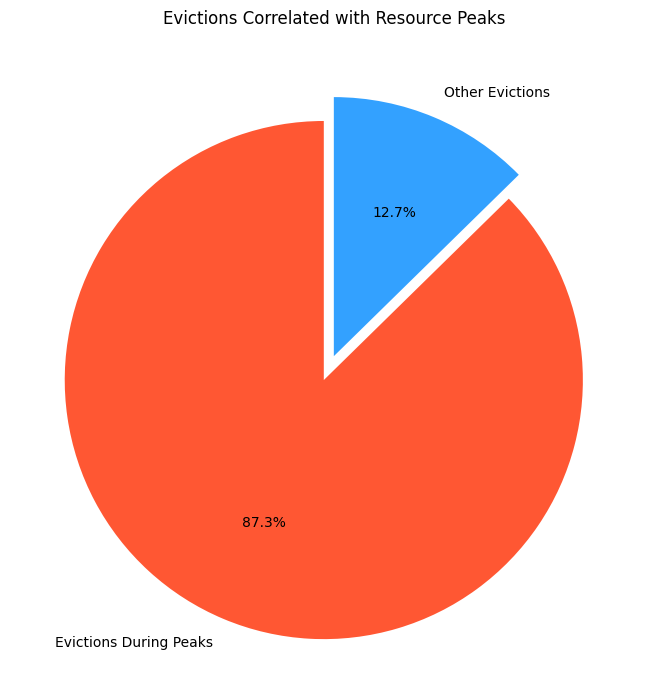

In [145]:
# Data for plotting
labels = ['Evictions During Peaks', 'Other Evictions']
sizes = [peak_evictions, total_evictions - peak_evictions]
colors = ['#FF5733', '#33A1FF']
explode = (0.1, 0)  # Slightly offset the first slice

# Create the plot
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title("Evictions Correlated with Resource Peaks")
plt.tight_layout()

# Save the plot
plt.savefig("../plots/q7_evictions_resource_peaks.png")

# Show the plot
plt.show()


## Q_8 : Task Priority vs Average Completion Time
This section analyzes the relationship between task priority and average completion time, focusing only on completed tasks.

Filter Finished Tasks and Join Datasets :

In [147]:
# Join task_events and task_usage on job_ID, task_index, and machine_ID
# Focus only on finished tasks (event_type = 4)
finished_tasks_df = task_events_df.filter(col("event_type") == 4).join(
    task_usage_df,
    (task_events_df["job_ID"] == task_usage_df["job_ID"]) &
    (task_events_df["task_index"] == task_usage_df["task_index"]) &
    (task_events_df["machine_ID"] == task_usage_df["machine_ID"]),
    "inner"
)


Calculate Average Completion Time by Priority :

In [148]:
# Calculate task completion time (end_time - start_time)
completion_time_df = finished_tasks_df.withColumn(
    "completion_time", (col("end_time") - col("start_time"))
)

# Group by priority and calculate the average completion time
priority_vs_completion_time = completion_time_df.groupBy("priority") \
    .agg(avg("completion_time").alias("avg_completion_time")) \
    .orderBy("priority")

# Show the result
priority_vs_completion_time.show()

[Stage 134:>                                                        (0 + 1) / 1]

+--------+--------------------+
|priority| avg_completion_time|
+--------+--------------------+
|       0|1.3382399841529243E8|
|       1|3.4589540412044376E7|
|       2|1.0103528274322903E8|
|       8|1.2083105981112278E8|
|       9| 4.918081180811808E7|
+--------+--------------------+



Plot Results :

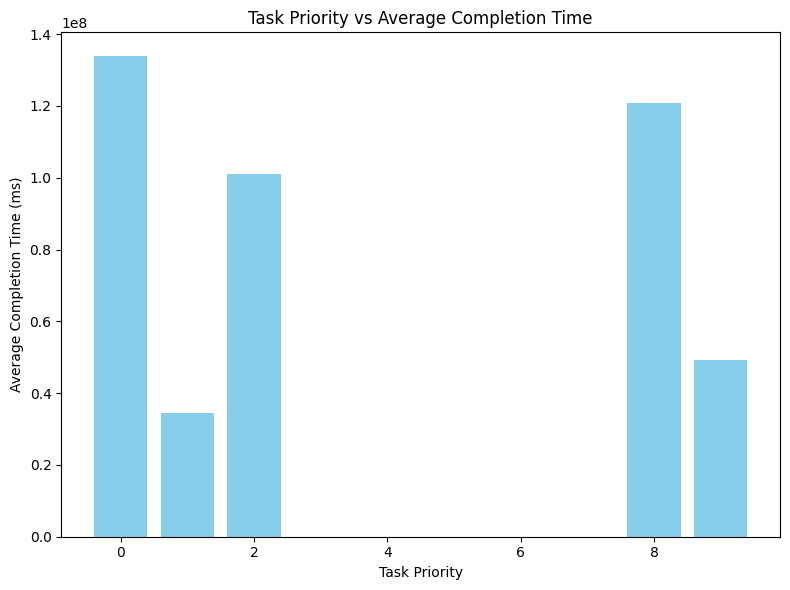

In [149]:
# Convert to Pandas for visualization
priority_vs_completion_time_pd = priority_vs_completion_time.toPandas()

import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(priority_vs_completion_time_pd["priority"], priority_vs_completion_time_pd["avg_completion_time"], color="skyblue")
plt.title("Task Priority vs Average Completion Time")
plt.xlabel("Task Priority")
plt.ylabel("Average Completion Time (ms)")
plt.tight_layout()

# Save and display the plot
plt.savefig("../plots/q8_priority_vs_completion_time.png")
plt.show()

## Q_9 : Failure Rate by Scheduling Class
This section calculates the failure rate of tasks for each scheduling class and visualizes the results as a bar chart.


Filter Failed Tasks, Count Total and Failed Tasks by Scheduling Class :

In [150]:
# Filter failed tasks (event_type = 3)
failed_tasks_df = task_events_df.filter(col("event_type") == 3)

# Count total tasks and failed tasks per scheduling class
total_tasks_by_class = task_events_df.groupBy("scheduling_class").count().withColumnRenamed("count", "total_tasks")
failed_tasks_by_class = failed_tasks_df.groupBy("scheduling_class").count().withColumnRenamed("count", "failed_tasks")


Compute Failure Rate :

In [151]:
# Join the two DataFrames to compute the failure rate
failure_rate_df = total_tasks_by_class.join(failed_tasks_by_class, "scheduling_class", "left").fillna(0, subset=["failed_tasks"])

# Calculate the failure rate as a percentage
failure_rate_df = failure_rate_df.withColumn(
    "failure_rate",
    (col("failed_tasks") / col("total_tasks")) * 100
)

# Show the results
failure_rate_df.select("scheduling_class", "total_tasks", "failed_tasks", "failure_rate").show()


[Stage 146:>                (0 + 1) / 1][Stage 147:>                (0 + 1) / 1]

+----------------+-----------+------------+--------------------+
|scheduling_class|total_tasks|failed_tasks|        failure_rate|
+----------------+-----------+------------+--------------------+
|               1|      58109|         129| 0.22199659261043903|
|               3|      56586|          36| 0.06361997667267523|
|               2|      97482|          44|0.045136538027533285|
|               0|     237969|         372| 0.15632288239224437|
+----------------+-----------+------------+--------------------+



Plot Results :

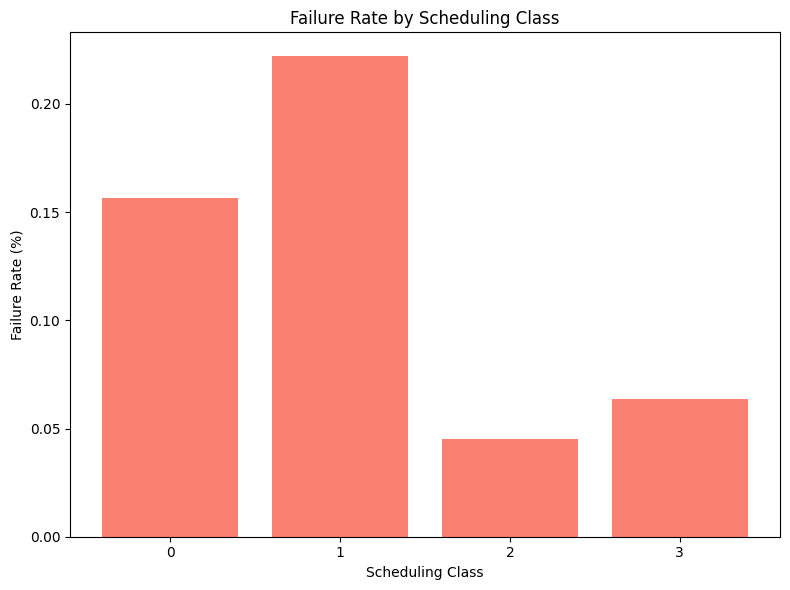

In [152]:
# Convert to Pandas for visualization
failure_rate_pd = failure_rate_df.toPandas()

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(failure_rate_pd["scheduling_class"], failure_rate_pd["failure_rate"], color="salmon")
plt.title("Failure Rate by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Failure Rate (%)")

# Set x-axis ticks explicitly to match scheduling classes
plt.xticks([0, 1, 2, 3])

plt.tight_layout()

# Save and display the plot
plt.savefig("../plots/q9_failure_rate_by_scheduling_class.png")
plt.show()


Stop SparkSession :

In [153]:
# Stop SparkSession
spark.stop()